# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
np.random.seed(0)

%matplotlib inline

# Instatiate a grid

Data from USGS hydrosheds project: https://hydrosheds.cr.usgs.gov/datadownload.php

In [2]:
grid = Grid.from_raster('../data/n30w100_con', data_name='dem')
grid.read_raster('../data/n30w100_dir', data_name='dir')

# Specify flow direction values

In [3]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Clip to a smaller area

In [4]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Clip to catchment
grid.clip_to('catch')
#grid.mask = np.ones_like(grid.mask).astype(bool)

# Generate random points

In [5]:
yi_s = np.random.randint(0, grid.shape[0], size=10)
xi_s = np.random.randint(0, grid.shape[1], size=10)
xs, ys = grid.affine * (xi_s, yi_s)

# Delineate catchments at random points

In [6]:
z0 = np.zeros(grid.shape)
i = 0

for x, y in zip(xs, ys):
    i += 1
    c = grid.catchment(x, y, data='dir', dirmap=dirmap, xytype='label', inplace=False)
    z0 += i * (c != 0).astype(int)

# Snap points to nearest high accumulation cells

In [7]:
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc', apply_mask=False)

In [8]:
xy = np.column_stack([xs, ys])
new_xy = grid.snap_to_mask(grid.acc > 50, xy, return_dist=False)
new_xs, new_ys = new_xy[:,0], new_xy[:,1]

# Delineate catchments at snapped points

In [9]:
z1 = np.zeros(grid.shape)
i = 0

for x, y in zip(new_xs, new_ys):
    i += 1
    c = grid.catchment(x, y, data='dir', dirmap=dirmap, xytype='label', inplace=False)
    z1 += i * (c != 0).astype(int)

# Plot results

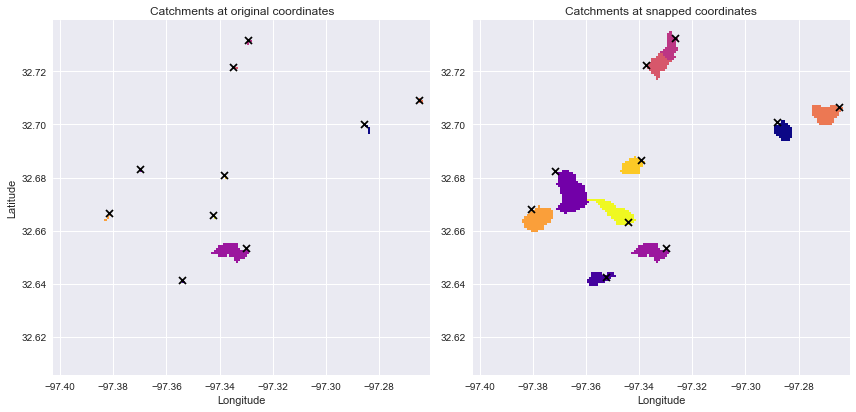

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

z0[z0 == 0] = np.nan
z1[z1 == 0] = np.nan

ax[0].imshow(z0, extent=grid.extent, zorder=1, cmap='plasma')
ax[0].scatter(xy[:,0], xy[:,1], marker='x', c='k', zorder=2)
ax[0].set_title('Catchments at original coordinates')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

ax[1].imshow(z1, extent=grid.extent, zorder=1, cmap='plasma')
ax[1].scatter(new_xy[:,0], new_xy[:,1], marker='x', c='k', zorder=2)
ax[1].set_title('Catchments at snapped coordinates')
ax[1].set_xlabel('Longitude')

plt.tight_layout()

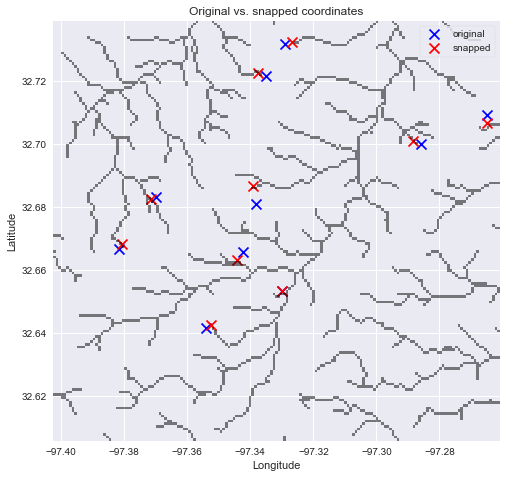

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

plt.scatter(xs, ys, marker='x', c='b', s=100, label='original')
plt.scatter(new_xs, new_ys, marker='x', c='r', s=100, label='snapped')
plt.legend(frameon=True)
plt.imshow(np.where(grid.acc > 50, 1, np.nan), extent=grid.extent, cmap='bone', zorder=1, alpha=0.5)
plt.title('Original vs. snapped coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')